**FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Build FCN Model and display summary

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train,  prep_coco_dataset
from mrcnn.coco            import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

## Notebook Preferences

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# def get_ax(rows=1, cols=1, size=16):
#     """Return a Matplotlib Axes array to be used in
#     all visualizations in the notebook. Provide a
#     central point to control graph sizes.
    
#     Adjust the size attribute to control how big to render images
#     """
#     _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
#     return ax


## Configurations

DIR_TRAINING = os.path.expanduser('/home/kbardool/models/')
FCN_TRAINING_PATH   = os.path.join(DIR_TRAINING  , "train_fcn_coco")
print(FCN_TRAINING_PATH)
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.BATCH_SIZE           = 1                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1               # Must match BATCH_SIZE
# fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.FCN_INPUT_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 
# fcn_config.FCN_VGG16_MODEL_PATH = mrcnn_config.FCN_VGG16_MODEL_PATH
fcn_config.TRAINING_PATH        = FCN_TRAINING_PATH
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4
 
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'
fcn_config.display()

## Build FCN Model

with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN8', config=fcn_config)

fcn_model.keras_model.summary()

Using TensorFlow backend.


/home/kbardool/models/train_fcn_coco

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SI

## Set weight files

In [2]:
# filepath = os.path.join(DIR_WEIGHTS, 'fcn_init_weights')
# fcn_model.keras_model.save_weights(filepath, overwrite=True)
# fcn_model.save_model(DIR_WEIGHTS, 'fcn_init_weights')
# fcn_model.keras_model.summary()
##'fcn_init_weights.h5',
# DIR_WEIGHTS =  'F:/models/train_fcn8_coco/fcn20181031T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization


# DIR_WEIGHTS = '/home/kbardool/models/train_fcn_coco/fcn20181023T0825'
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181026T1432'
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181028T1324' ### Training with LR=0.0001, MSE Loss
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181030T0000' ### Training with LR=0.0001, MSE Loss NO L2 Regularization
# DIR_WEIGHTS =  '/home/kbardool/models/train_fcn8_coco/fcn20181031T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
DIR_WEIGHTS =  '/home/kbardool/models/train_fcn8_coco/fcn20181106T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization

# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
files   = ['fcn_0001.h5','fcn_0009.h5','fcn_0028.h5','fcn_0053.h5','fcn_0101.h5','fcn_0105.h5']

## Load Weights - 1

In [3]:
weights_path = os.path.join(DIR_WEIGHTS  , files[0])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0001.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0001.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0001.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0001.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 1st weight file

In [4]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[0]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678041950,+0.0678041279,+0.0391484238
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000082255,+0.0000103196,+0.0000065610
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721738786,+0.0721665472,+0.0416168123
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000090760,+0.0000108392,+0.0000066268
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589247346,+0.0589304678,+0.0340644494
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000097190,+0.0000109400,+0.0000068249
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510307029,+0.0510327891,+0.0294395071
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000097833,+0.0000107638,+0.0000074916
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416747741,+0.0416702442,+0.0240496602
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000100606,+0.0000104786,+0.0000076235


In [ ]:
from mrcnn.utils import convertHtmlToPdf

### Histograms of Weights - 1st weight file

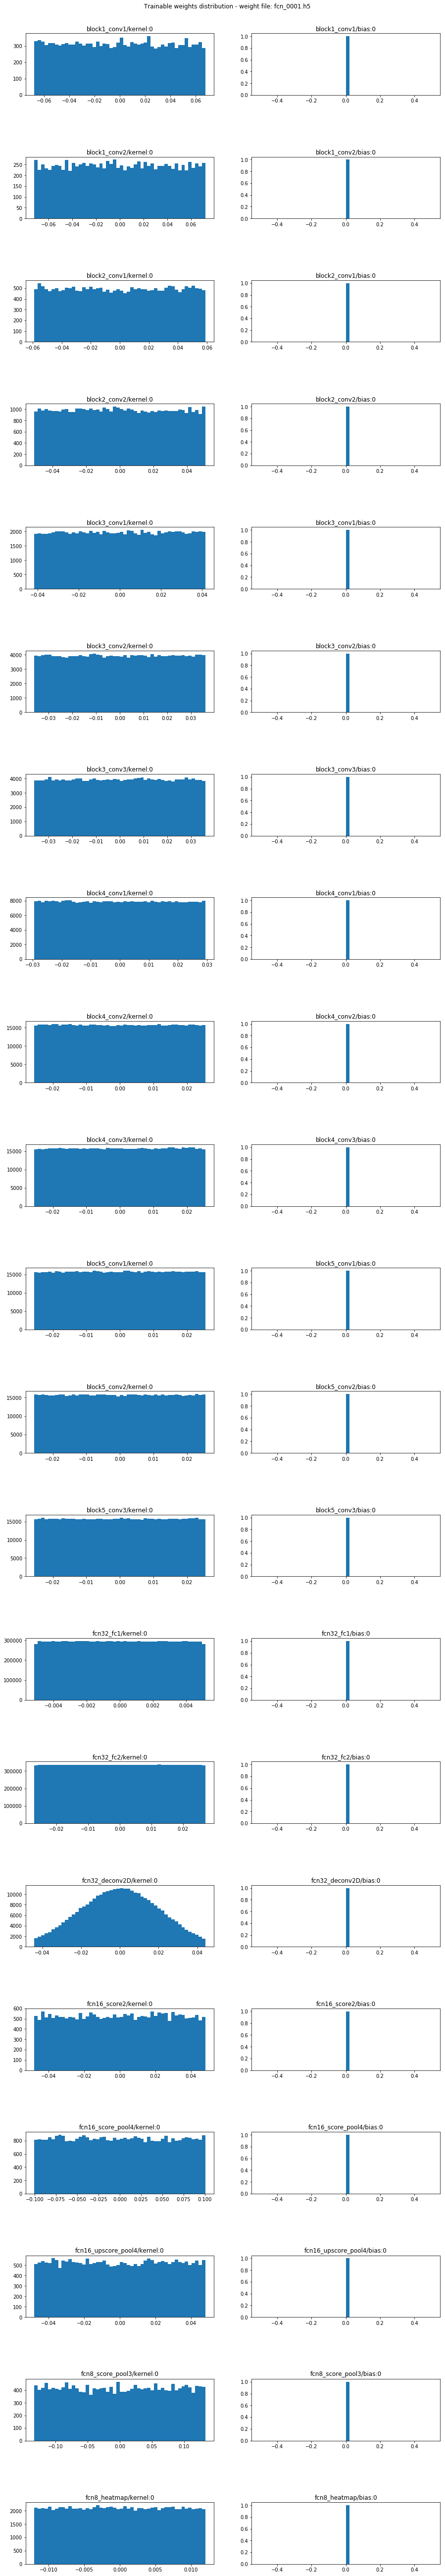

In [5]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[0])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[0]+'.png')
a.savefig(weights_histogram)

## Load Weights - 2

In [7]:
weights_path = os.path.join(DIR_WEIGHTS  , files[1])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0009.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0009.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0009.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0009.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 2nd weights file

In [8]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678040385,+0.0678048134,+0.0391485021
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000174400,+0.0000218655,+0.0000124946
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721772239,+0.0721738413,+0.0416169353
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000191823,+0.0000218400,+0.0000138093
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589268021,+0.0589386858,+0.0340645127
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000190724,+0.0000229249,+0.0000141613
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510394014,+0.0510417931,+0.0294395536
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000212935,+0.0000228907,+0.0000158254
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416832156,+0.0416791625,+0.0240497030
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000219946,+0.0000229179,+0.0000164772


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.0678040385</td><td>+0.0678048134</td><td>+0.0391485021</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000174400</td><td>+0.0000218655</td><td>+0.0000124946</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.0721772239</td><td>+0.0721738413</td><td>+0.0416169353</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000191823</td><td>+0.0000218400</td><td>+0.0000138093</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0589268021</td><td>+0.0589386858</td><td>+0.0340645127</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 2nd weights file

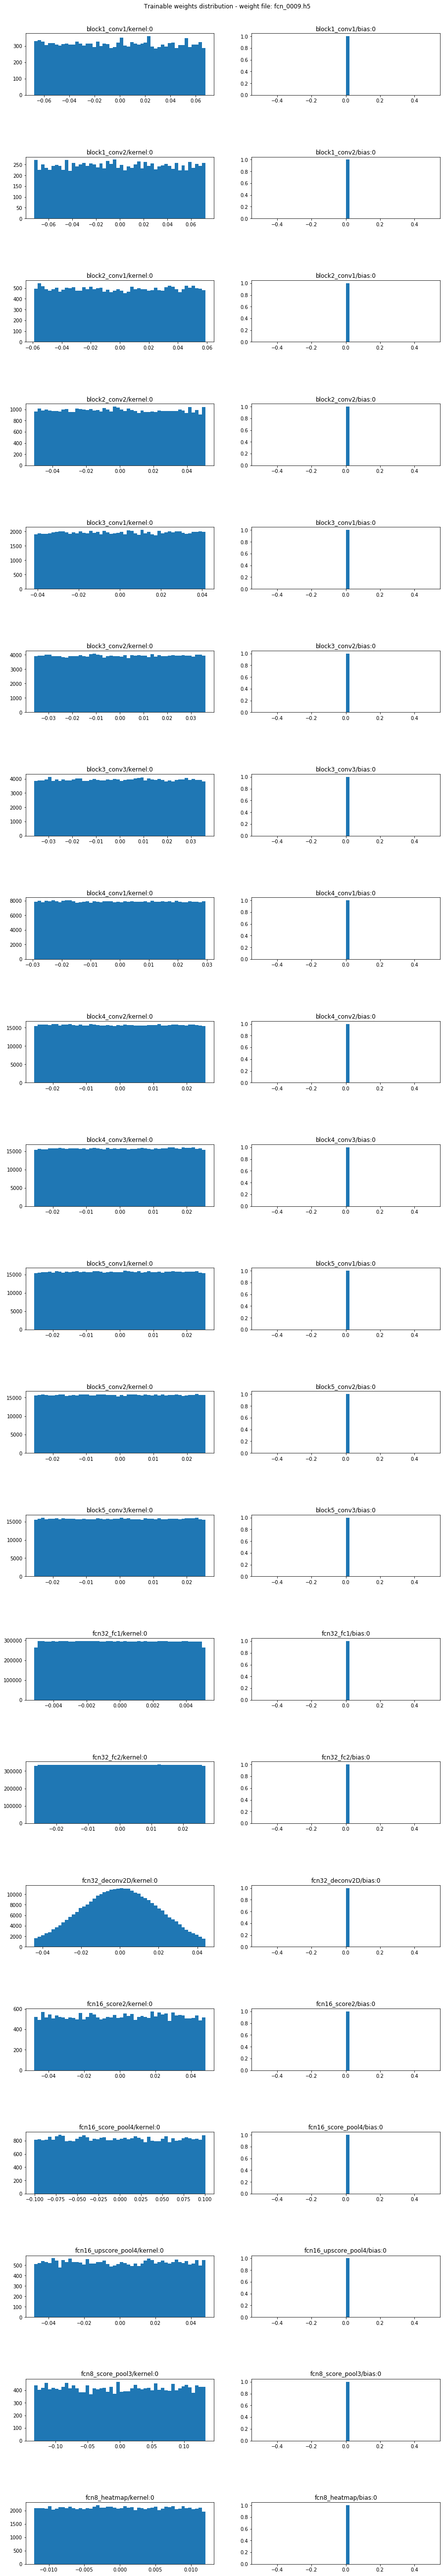

In [9]:
a = visualize.display_weight_histograms(fcn_model, filename = files[1])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[1]+'.png')
a.savefig(weights_histogram)

## Load Weights - 3rd weight file

### load

In [10]:
weights_path = os.path.join(DIR_WEIGHTS  , files[2])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0028.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0028.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0028.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0028.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 3rd weight file

In [13]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)


LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678040385,+0.0678055435,+0.0391485579
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000211093,+0.0000264791,+0.0000148289
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721776262,+0.0721772760,+0.0416170061
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000233924,+0.0000265486,+0.0000165003
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589289591,+0.0589415953,+0.0340645537
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000233350,+0.0000277643,+0.0000171349
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510426126,+0.0510459505,+0.0294395797
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000256223,+0.0000277401,+0.0000191887
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416865721,+0.0416831858,+0.0240497254
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000264207,+0.0000275936,+0.0000199700


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.0678040385</td><td>+0.0678055435</td><td>+0.0391485579</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000211093</td><td>+0.0000264791</td><td>+0.0000148289</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.0721776262</td><td>+0.0721772760</td><td>+0.0416170061</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000233924</td><td>+0.0000265486</td><td>+0.0000165003</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0589289591</td><td>+0.0589415953</td><td>+0.0340645537</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 3rd weight file

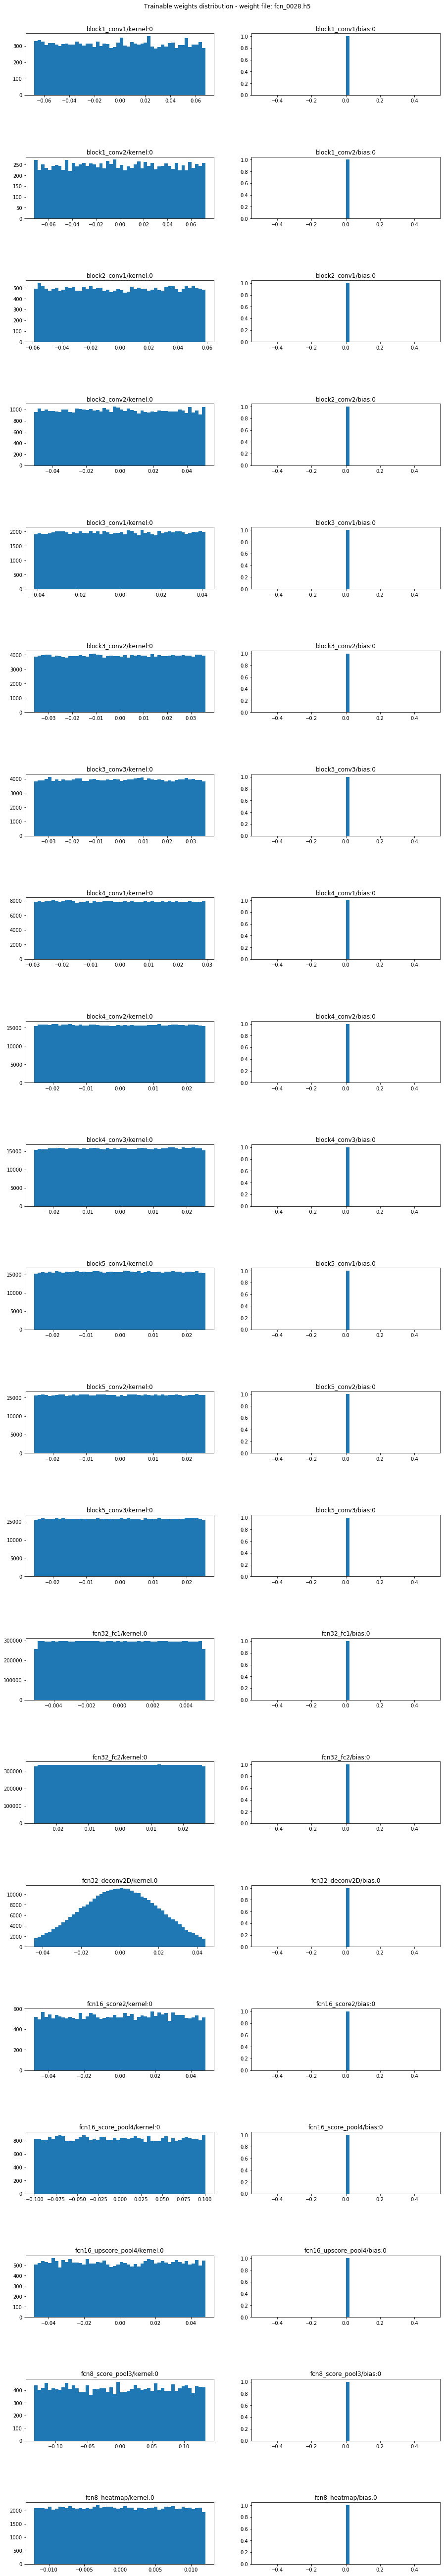

In [14]:
a = visualize.display_weight_histograms(fcn_model, filename = files[2])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[2]+'.png')
a.savefig(weights_histogram)

## Load Weights - 4rd weight file

In [17]:
weights_path = os.path.join(DIR_WEIGHTS  , files[3])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path, verbose = 1) 

Loading weights  /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0053.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0053.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0053.h5
layers type:  <class 'list'> length:  33
 Weight Matchup between model and HDF5 weights 

  0 input_pr_hm_norm          Model Layer Name/Type : [['input_pr_hm_norm', 'InputLayer']] 

  1 block1_conv1              Model Layer Name/Type : [['block1_conv1', 'Conv2D']] 
    0 block1_conv1/kernel:0                hdf5 Weights: (3, 3, 81, 64)  		 Symbolic Wghts: (3, 3, 81, 64)   
    1 block1_conv1/bias:0                  hdf5 Weights: (64,)  		 Symbolic Wghts: (64,)   

  2 block1_conv2              Model Layer Name/Type : [['block1_conv2', 'Conv2D']] 
    0 block1_conv2/kernel:0                hdf5

    Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0053.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 4th weight file

In [16]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678040758,+0.0678059086,+0.0391485803
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000226103,+0.0000284624,+0.0000157851
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721776634,+0.0721777454,+0.0416170247
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000251173,+0.0000285066,+0.0000175428
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589295886,+0.0589428246,+0.0340645723
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000250721,+0.0000296738,+0.0000183186
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510437600,+0.0510476194,+0.0294395946
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000271131,+0.0000296893,+0.0000205363
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416877605,+0.0416845493,+0.0240497366
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000282675,+0.0000295062,+0.0000213560


### Histograms of Weights

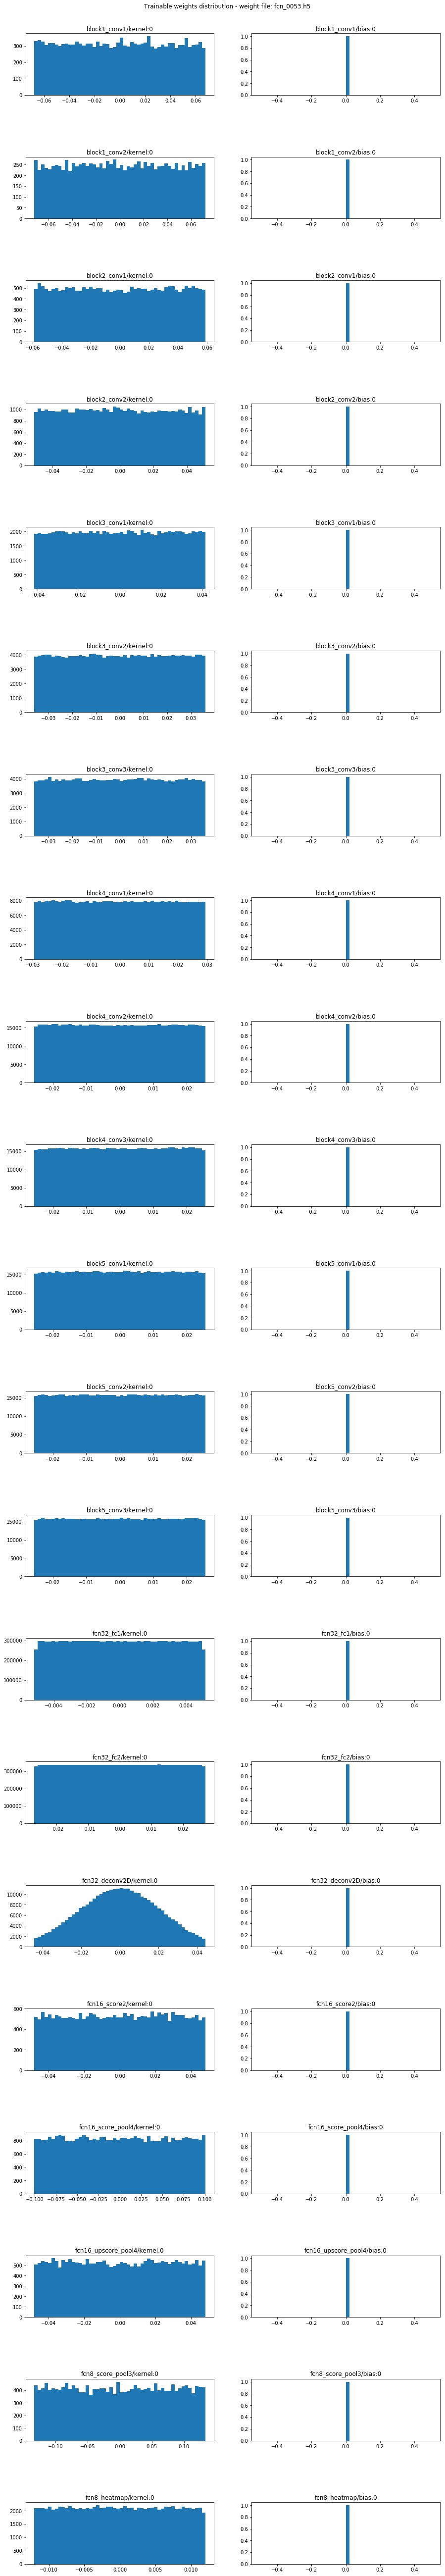

In [18]:
a = visualize.display_weight_histograms(fcn_model, filename = files[3])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[3]+'.png')
a.savefig(weights_histogram)

## Load Weights - 5th weight file

In [19]:
weights_path = os.path.join(DIR_WEIGHTS  , files[4])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0101.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0101.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0101.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 5th weight file

In [20]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678048059,+0.0678066164,+0.0391486809
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000313857,+0.0000410842,+0.0000218828
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721788108,+0.0721882582,+0.0416172370
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000367511,+0.0000410193,+0.0000242237
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589360110,+0.0589535236,+0.0340647139
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000363206,+0.0000418296,+0.0000261712
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510496423,+0.0510606132,+0.0294396877
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000382039,+0.0000422964,+0.0000295313
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416966304,+0.0416961201,+0.0240498111
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000404519,+0.0000419725,+0.0000306421


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.0678048059</td><td>+0.0678066164</td><td>+0.0391486809</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000313857</td><td>+0.0000410842</td><td>+0.0000218828</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.0721788108</td><td>+0.0721882582</td><td>+0.0416172370</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000367511</td><td>+0.0000410193</td><td>+0.0000242237</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0589360110</td><td>+0.0589535236</td><td>+0.0340647139</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 5th weight file

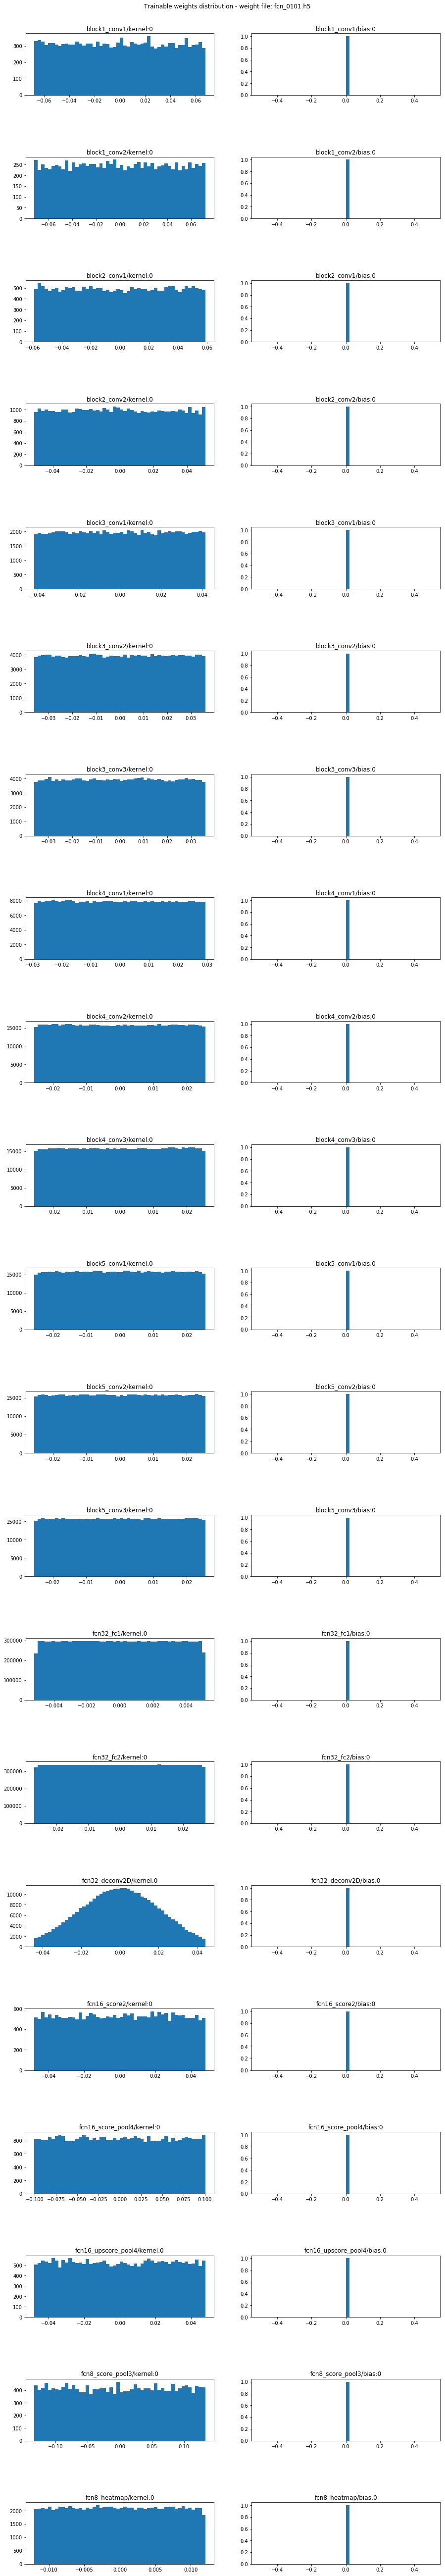

In [21]:
a = visualize.display_weight_histograms(fcn_model, filename = files[4])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[4]+'.png')
a.savefig(weights_histogram)

## Load Weights - 6th weight file

In [22]:
weights_path = os.path.join(DIR_WEIGHTS  , files[5])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0105.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0105.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181106T0000/fcn_0105.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 6th weight file

In [23]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678049251,+0.0678079277,+0.0391488075
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000369260,+0.0000492549,+0.0000259793
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721817240,+0.0721945986,+0.0416173786
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000445077,+0.0000490948,+0.0000291074
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589397922,+0.0589582324,+0.0340648182
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000439455,+0.0000501624,+0.0000316149
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510541461,+0.0510682464,+0.0294397604
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000462509,+0.0000506449,+0.0000354978
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0417030789,+0.0417032912,+0.0240498632
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000484400,+0.0000510614,+0.0000366919


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.0678049251</td><td>+0.0678079277</td><td>+0.0391488075</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000369260</td><td>+0.0000492549</td><td>+0.0000259793</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.0721817240</td><td>+0.0721945986</td><td>+0.0416173786</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000445077</td><td>+0.0000490948</td><td>+0.0000291074</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0589397922</td><td>+0.0589582324</td><td>+0.0340648182</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 6th weight file

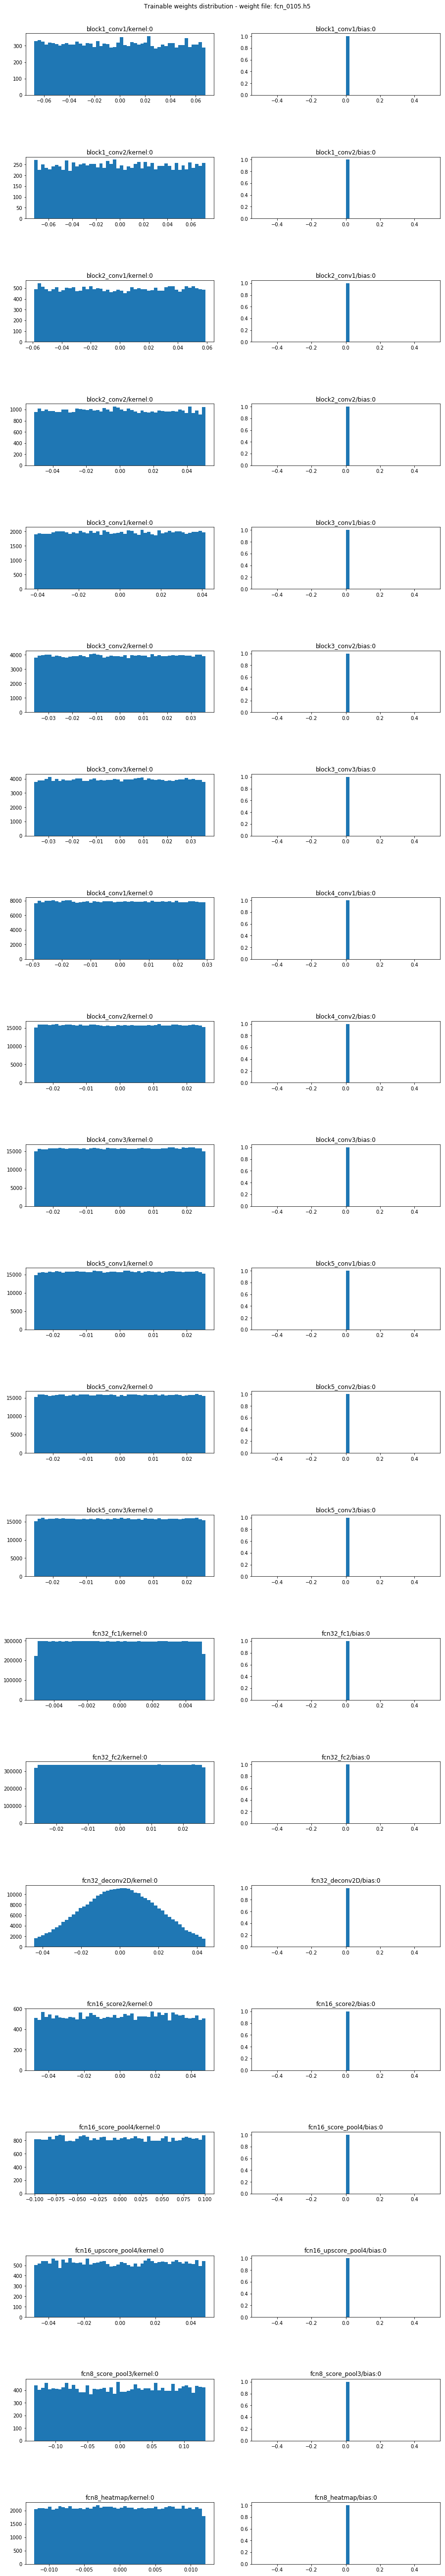

In [24]:
a = visualize.display_weight_histograms(fcn_model, filename = files[5])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[5]+'.png')
a.savefig(weights_histogram)

## Load Weights - 7th weight file

In [26]:
weights_path = os.path.join(DIR_WEIGHTS  , files[6])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco/fcn20181031T0000/fcn_2623.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco/fcn20181031T0000/fcn_2623.h5
layers type:  <class 'list'> length:  33
   Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181031T0000/fcn_2623.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 7th weight file

In [27]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1060099304,+0.0975227505,+0.0397304296
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0519839823,+0.0132924858,+0.0157960132
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032653749,+0.0987138823,+0.0424404778
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0369750783,+0.0037930820,+0.0092559457
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962980315,+0.0861869976,+0.0347781889
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0331014171,+0.0160394702,+0.0106049469
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903631896,+0.0923697725,+0.0302444026
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285101533,+0.0136098573,+0.0083528310
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849121511,+0.0884306729,+0.0249463562
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301018562,+0.0231480617,+0.0093590338


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.1060099304</td><td>+0.0975227505</td><td>+0.0397304296</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0519839823</td><td>+0.0132924858</td><td>+0.0157960132</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.1032653749</td><td>+0.0987138823</td><td>+0.0424404778</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0369750783</td><td>+0.0037930820</td><td>+0.0092559457</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0962980315</td><td>+0.0861869976</td><td>+0.0347781889</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 7th weight file

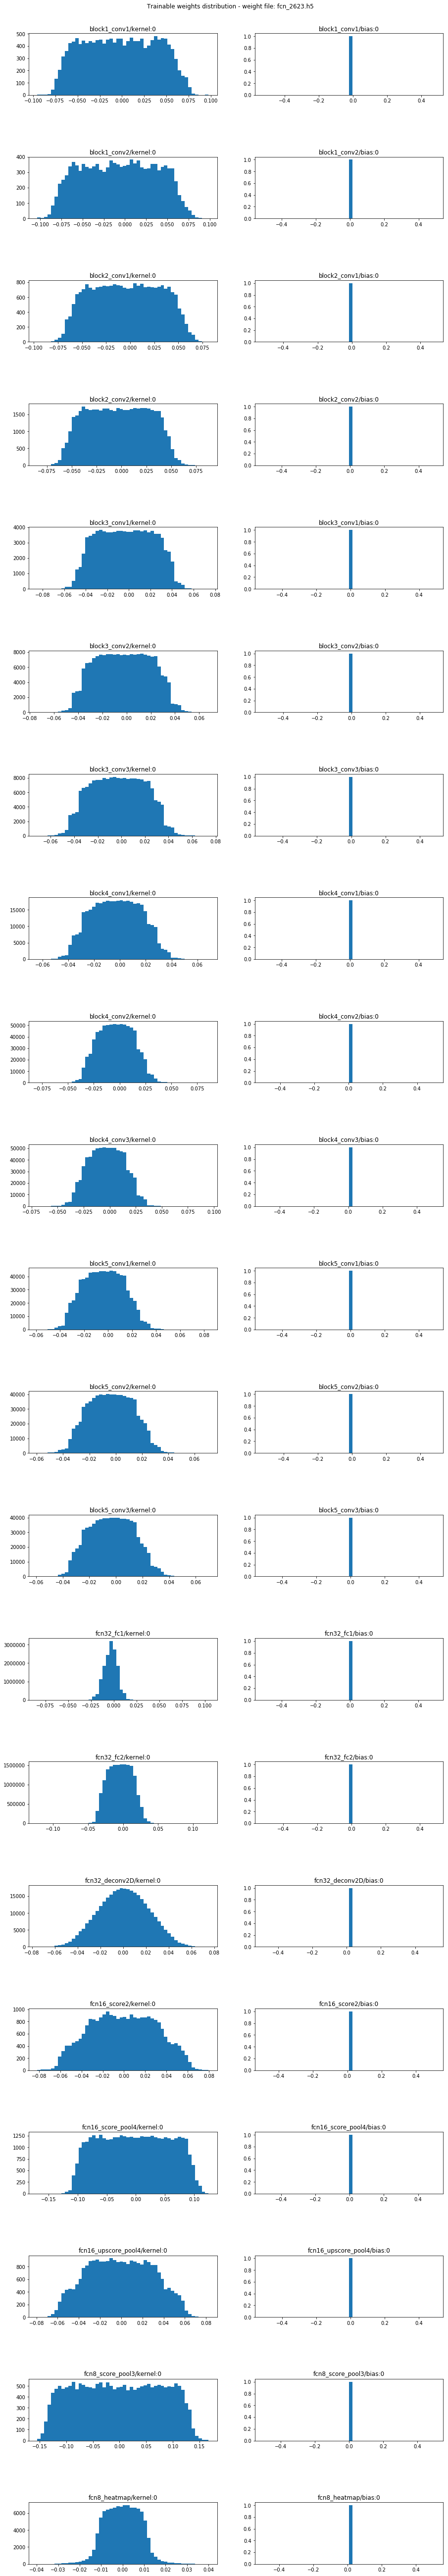

In [28]:
a = visualize.display_weight_histograms(fcn_model, filename = files[6])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
a.savefig(weights_histogram)